In [1]:
import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("nbAgg") # Have to first change to a different backend in order to get the classes to reload on the next line.
# mpl.use("module://ipympl.backend_nbagg")
# mpl.use("module://" + __name__)

mpl.get_backend()

'module://matplotlib_inline.backend_inline'

In [2]:
import IPython
IPython.get_ipython().kernel.shell.ast_transformers = []

In [3]:
trivial_names = set(dir(object()))

def tag_with_paths_deep(artist, path_str):
  if hasattr(artist, "_snp_names"):
    if path_str not in artist._snp_names:
      artist._snp_names.add(path_str)
    # print(entry)
  else:
    try:
      artist._snp_names = {path_str}
      # print(entry)
    except:
      pass # can't set new attrs on primitives
  
  # out += textbox("_suptitle", artist._suptitle)
  children = artist.get_children()

  for name in dir(artist):
    # if not name.startswith("_"):
    with mpl._api.deprecation.suppress_matplotlib_deprecation_warning():
      value = getattr(artist, name)
    if not callable(value) and name not in trivial_names:
      if isinstance(value, list):
        for i, item in enumerate(value):
          if item in children:
            tag_with_paths_deep(item, path_str + "." + name + "[" + str(i) + "]")
      else:
        if value in children:
          tag_with_paths_deep(value, path_str + "." + name)

def flatten(lists):
    return sum(lists, []) # https://stackoverflow.com/a/952946

def remove_nones(iter):
  return [x for x in iter if x is not None]

def all_artists(artist):
    if "get_children" in dir(artist):
        return [artist] + flatten([all_artists(artist) for artist in artist.get_children()])
    else:
        return [artist]

import shapely

# returns shapely.Polygon
def mpl_bbox_to_shapely(bbox):
  return shapely.box(*bbox.extents)

# returns numpy ndarray of [xmin, ymin, xmax, ymax]
def total_bounds(geometries):
  return shapely.total_bounds(shapely.GeometryCollection(geometries))

# returns shapely.Polygon
def total_bbox(geometries):
  return shapely.box(*total_bounds(geometries))

# returns list of (artist, shapley.Geometry)
def flatten_regions(artist_geom_children):
  artist, geom, children = artist_geom_children
  return [(artist, geom)] + flatten([flatten_regions(child) for child in children])

# Make sure to render before calling this.
# returns (artist, shapley.Geometry, children)
def regions(artist : mpl.artist.Artist):
  child_pad = 3

  if "get_children" in dir(artist):
    children = artist.get_children()
  else:
    children = []

  match artist:
    case mpl.axis.Tick():
      # Remove invisible tick text (i.e. the rarely used label2, which is mispositioned when not actively used.)
      children = [child for child in children if child.get_visible()]

  child_regions      = remove_nones([regions(child) for child in children])
  child_regions_flat = flatten([flatten_regions(child_region) for child_region in child_regions])
  child_geoms        = [geom for _, geom in child_regions_flat]

  # print(artist)
  match artist:
    case mpl.text.Text() as text:
      # based on mpl text.py contains
      bbox = mpl.text.Text.get_window_extent(text)
      my_geom = mpl_bbox_to_shapely(bbox)
    case mpl.patches.Rectangle() as rect:
      my_geom = mpl_bbox_to_shapely(rect.get_bbox())
    case mpl.lines.Line2D() as line:
      # based on mpl lines.py contains
      if line._xy is None or len(line._xy) == 0:
        # print("line has no path: " + str(line))
        my_geom = None
      else:
        transformed_path = line._get_transformed_path()
        path = transformed_path.get_fully_transformed_path()
        if len(path.vertices) >= 2:
          line_string = shapely.LineString(path.vertices)
          my_geom = shapely.buffer(line_string, child_pad + line.get_linewidth(), quad_segs=1, cap_style='square', join_style='mitre') # expand outward
        elif len(path.vertices) == 1:
          d = 10 + line.get_linewidth()
          my_geom = shapely.box(
            path.vertices[0,0] - d,
            path.vertices[0,1] - d,
            path.vertices[0,0] + d,
            path.vertices[0,1] + d,
          )
        else:
          print("a;sdkjf;laskdj;lsaknvad")
    case mpl.axes._subplots.SubplotBase():
      my_geom = None
    case _:
      # print("regions(): unknown artist: " + str(artist))
      my_geom = None

  if my_geom is None and len(child_geoms) == 0:
    return None
  elif my_geom is None:
    my_geom = total_bbox(child_geoms)
  else:
    my_geom = shapely.union_all([my_geom, total_bbox(child_geoms)])

  my_geom = shapely.buffer(my_geom, child_pad, quad_segs = 1, cap_style='square', join_style='mitre') # expand by 10px

  return (artist, my_geom, child_regions)


    # def contains(self, mouseevent):
    #     """
    #     Return whether the mouse event occurred inside the axis-aligned
    #     bounding-box of the text.
    #     """
    #     inside, info = self._default_contains(mouseevent)
    #     if inside is not None:
    #         return inside, info

    #     if not self.get_visible() or self._renderer is None:
    #         return False, {}

    #     # Explicitly use Text.get_window_extent(self) and not
    #     # self.get_window_extent() so that Annotation.contains does not
    #     # accidentally cover the entire annotation bounding box.
    #     bbox = Text.get_window_extent(self)
    #     inside = (bbox.x0 <= mouseevent.x <= bbox.x1
    #               and bbox.y0 <= mouseevent.y <= bbox.y1)

    #     cattr = {}
    #     # if the text has a surrounding patch, also check containment for it,
    #     # and merge the results with the results for the text.
    #     if self._bbox_patch:
    #         patch_inside, patch_cattr = self._bbox_patch.contains(mouseevent)
    #         inside = inside or patch_inside
    #         cattr["bbox_patch"] = patch_cattr

    #     return inside, cattr

# text = ax.text(0.5, 0.5, "hi")

# tag_with_paths_deep(fig, "fig")
# tag_with_paths_deep(ax, "ax")

# regions(fig)

In [4]:
import io
import base64
import pathlib
import re
import json

# fig.suptitle(None)

# def snp_inspector_html(self):
#   out = '<details style="padding-left: 1em; border: solid 1px black">'
#   out += "<summary>" + str(self._snp_names) + "</summary>"
#   out += str(self)
#   # out += textbox("_suptitle", self._suptitle)
#   children = self.get_children()

#   visited_children = []

#   for name in dir(self):
#     # if not name.startswith("_"):
#     with mpl._api.deprecation.suppress_matplotlib_deprecation_warning():
#       value = getattr(self, name)
#     if not callable(value) and name not in trivial_names:
#       if isinstance(value, list):
#         for i, item in enumerate(value):
#           if item in children:
#             if item not in visited_children:
#               out += item.snp_inspector_html()
#               visited_children.append(item)
#           else:
#             out += "<div>" + name  + "[" + str(i) + "]: " + str(item)[0:100] + "</div>"
#       else:
#         if value in children:
#           if value not in visited_children:
#             out += value.snp_inspector_html()
#             visited_children.append(value)
#         else:
#           out += "<div>" + name + ": " + str(value)[0:100] + "</div>"

#   out += "</details>"
#   return out

# setattr(mpl.artist.Artist, "snp_inspector_html", snp_inspector_html)
# setattr(matplotlib.figure.FigureBase, "snp_inspector_html", figure_snp_inspector_html)


# # Preserve heirarchical structure so that JS mouseenter events work as intended
def region_to_svg_g(artist_geom_children):
    artist, geom, children = artist_geom_children
    geom_svg = geom.svg()
    geom_svg = re.sub(r'fill="[^"]*"', 'fill="transparent"', geom_svg) # can't be "none", otherwise no mouse events are triggered inside the region
    geom_svg = re.sub(r'stroke-width="[^"]*"', 'stroke-width="0.25"', geom_svg)
    # geom_svg = re.sub(r'\A(<\w+)', f'\\1 data-object="{str(artist)}"', geom_svg)
    child_svgs_str = "\n".join([region_to_svg_g(child) for child in children])
    perhaps_data_names = f'data-names="{json.dumps(list(artist._snp_names))}"' if hasattr(artist, "_snp_names") else ""
    perhaps_code_loc = f'data-loc="{json.dumps(artist._snp_loc)}"' if hasattr(artist, "_snp_loc") else ""
    return f"""<g data-artist="{str(artist)}" {perhaps_data_names} {perhaps_code_loc}>
    {geom_svg}
    {child_svgs_str}
    </g>"""


class SNP():
    def __init__(self, figure):
        self.figure = figure
        self.cached_png = None;
        self.cached_svg_hover_regions = None;

    def _repr_png_(self):
        if (self.cached_png == None):
            buf = io.BytesIO()
#             self.figure.savefig(buf, format='png', dpi='figure') # not tight version
            self.figure.canvas.print_figure(buf, format='png', dpi='figure', bbox_inches='tight', pad_inches=mpl.rcParams['savefig.pad_inches']) # tight version
            self.cached_png = buf.getvalue()
        
        return self.cached_png

    # Note this is the hover regions only.
    def _repr_svg_(self):
        if (self.cached_svg_hover_regions == None):
            self._repr_png_() # Ensure elements are laid out.

            #         width_px  = self.figure.get_figwidth() * self.figure.get_dpi()
    #         height_px = self.figure.get_figheight() * self.figure.get_dpi()

            bbox_inches = fig.get_tightbbox(fig.canvas.renderer).padded(mpl.rcParams['savefig.pad_inches'])
            x0_px       = bbox_inches.x0 * fig.get_dpi()
            y0_px       = bbox_inches.y0 * fig.get_dpi()
            width_px    = bbox_inches.width * fig.get_dpi()
            height_px   = bbox_inches.height * fig.get_dpi()

            # fig_regions = flatten_regions(regions(fig))
            fig_regions = regions(self.figure)

            svg_body = region_to_svg_g(fig_regions)

            # for artist, shape in fig_regions:
            #   shape_svg = shape.svg()
            #   # shape_svg = re.sub(r'fill="[^"]*"', 'fill="transparent"', shape_svg)
            #   shape_svg = re.sub(r'stroke-width="[^"]*"', 'stroke-width="1.0"', shape_svg)
            #   shape_svg = re.sub(r'\A(<\w+)', f'\\1 data-object="{str(artist)}"', shape_svg)
            #   svg_body += shape_svg
            
            self.cached_svg_hover_regions = f"""<svg style="margin: 0; border: solid 1px black; position: absolute; top: 0; left: 0;" transform="scale(1,-1)" width={width_px} height={height_px} viewBox="{x0_px} {y0_px} {width_px} {height_px}">
                {svg_body}
            </svg>"""

        return self.cached_svg_hover_regions
    
    def _repr_html_(self):
        # ripped the below from ipympl/backend_nbagg.py
        base64_image = base64.b64encode(self._repr_png_()).decode('utf-8')
        data_url = f'data:image/png;base64,{base64_image}'

        return f"""
            <div class="snp_outer" style="position:relative;">
            <script>
            {pathlib.Path("snp.js").read_text()}
            </script>
            <style>
            .snp_outer > svg g.hovered > path {{
              stroke-width: 3.0;
            }}
            </style>
            <img style="margin: 0; border: solid 1px black;" src='{data_url}' onload="attach_snp(this)">
            {self._repr_svg_()}
            </div>
        """
        # return "<b id='asdf'>bold</b><script>console.log(IPython.notebook.notebook_name); console.log(Jupyter.notebook.get_cells()); document.querySelector('#asdf').innerHTML = '' + Jupyter.notebook.get_cells();</script>"
        # return { "text/html": "<b><script>alert('hi');</script>bold</b>" }


In [5]:
import IPython

IPython.get_ipython().kernel.shell.ast_transformers = []

In [6]:
import IPython
import ast
# import astor
# Thanks GPT-4, this works, apparently.

class LocedTuple(tuple):
    def __new__(cls, iterable, loc):
        out = tuple.__new__(cls, iterable)
        out._snp_loc = loc
        return out
    
class LocedStr(str):
    def __new__(cls, string, loc):
        out = str.__new__(cls, string)
        out._snp_loc = loc
        return out
    
class LocedList(list):
    def __init__(self, iterable, loc):
        self._snp_loc = loc
        super().__init__(iterable)

class LocedDict(dict):
    def __init__(self, dictionary, loc):
        self._snp_loc = loc
        super().__init__(dictionary)

class LocedInt(int):
    def __new__(cls, x, loc):
        out = int.__new__(cls, x)
        out._snp_loc = loc
        return out

class LocedFloat(float):
    def __new__(cls, x, loc):
        out = float.__new__(cls, x)
        out._snp_loc = loc
        return out

# code = \
# """
# fig, ax = plt.subplots()
# # ax.set_title(label, fontdict=None, loc='center', pad=None, **kwargs)
# ax.set_title("My Plot")
# # xs = np.linspace(0, 2 * np.pi, 20)
# # ys = np.sin(xs)
# # lines = ax.plot(xs, ys)
# """

# print(code)
# tree = ast.parse(code)

def tag_with_provenance(obj, lineno, col_offset, end_lineno, end_col_offset):
    if hasattr(obj, "_snp_loc"):
        return obj # Don't rewrite oldest loc.

    loc = (lineno, col_offset, end_lineno, end_col_offset)

    if isinstance(obj, tuple):
        return LocedTuple(obj, loc)
    elif isinstance(obj, str):
        return LocedStr(obj, loc)
    elif isinstance(obj, list):
        return LocedList([tag_with_provenance(child, lineno, col_offset, end_lineno, end_col_offset) for child in obj], loc)
    elif isinstance(obj, dict):
        return LocedDict(obj, loc)
    elif isinstance(obj, int):
        return LocedInt(obj, loc)
    elif isinstance(obj, float):
        return LocedFloat(obj, loc)

    try:
        obj._snp_loc = loc
        return obj
    except:
        return obj

class ProvenanceTagger(ast.NodeTransformer):
    def visit_Call(self, node):
        loc = (node.lineno, node.col_offset, node.end_lineno, node.end_col_offset)
#         print(loc)
        wrapped = ast.Call(ast.Name("tag_with_provenance", ast.Load()), [
            node,
            ast.Constant(node.lineno),
            ast.Constant(node.col_offset),
            ast.Constant(node.end_lineno),
            ast.Constant(node.end_col_offset)
        ], [])
#         print(ast.unparse(wrapped))
        return wrapped

# print(astor.dump_tree(ast.parse(tree)))

# print(ast.unparse(ProvenanceTagger().visit(tree)))

In [7]:
IPython.get_ipython().kernel.shell.ast_transformers = [ProvenanceTagger()]

In [8]:
IPython.get_ipython().kernel.shell.ast_transformers

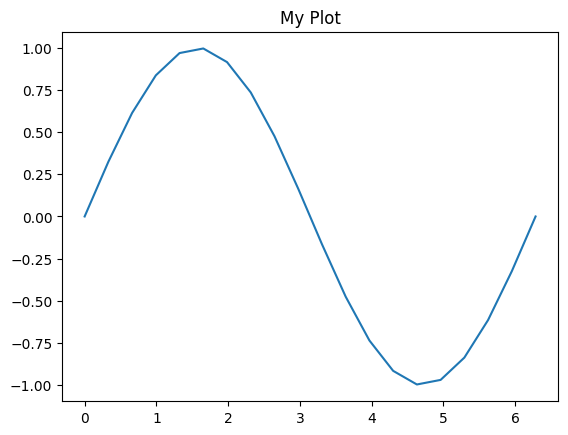

current_notebook.py:11: error: Skipping analyzing "IPython": module is installed, but missing library stubs or py.typed marker  [import]
current_notebook.py:11: note: See https://mypy.readthedocs.io/en/stable/running_mypy.html#missing-imports
current_notebook.py:55: error: Skipping analyzing "shapely": module is installed, but missing library stubs or py.typed marker  [import]
current_notebook.py:103: error: "Line2D" has no attribute "_xy"  [attr-defined]
current_notebook.py:107: error: "Line2D" has no attribute "_get_transformed_path"  [attr-defined]


In [475]:
# mpl.use("module://matplotlib_inline.backend_inline")
plt.ioff()
fig, ax = plt.subplots()
# ax.set_title(label, fontdict=None, loc='center', pad=None, **kwargs)
text = ax.set_title("My Plot", fontdict={}, loc="center", pad=6, y=
  0.63)
xs = np.linspace(0, 2 * np.pi, 20)
ys = np.sin(xs)
lines = ax.plot(xs, ys)

# text._snp_loc

# This is slow (lol):
# tag_with_paths_deep(fig, "fig")
# tag_with_paths_deep(ax, "ax")

# pathlib.Path('scratch/snp.html').write_text(SNP(fig)._repr_html_())

SNP(fig)

In [415]:
%%javascript

let cell = Jupyter.notebook.get_cells().find(cell => cell.get_text().includes("\nSNP(fig)"))

infer_types_up_through(cell)

<IPython.core.display.Javascript object>

In [ ]:
%%javascript

let cell = Jupyter.notebook.get_cells().find(cell => cell.get_text().includes("\nSNP(fig)"))
// console.log(cell.get_text())


const call_regex = /\w+\.\w+\(.*\)/g;

cell.code_mirror.doc.getAllMarks().forEach(mark => mark.clear())

cell.code_mirror.eachLine(line => {
    Array.from(line.text.matchAll(call_regex)).forEach(match => {
        // console.log(line.lineNo(), line.text, match.index)
        // console.log(match)

//         let ellipses = document.createElement("span");
// //         let ellipses = document.createElementNS("http://www.w3.org/2000/svg", "svg");
//         ellipses.innerHTML = `, <svg style="vertical-align: middle" x="0pt" y="0pt" width="14pt" height="14pt" viewBox="0 0 14 14" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
//                  <g id="1">
//                 <title>Layer 1</title>
//                 <defs>
//                   <title>Smart Rectangle1</title>
//                   <g id="2">
//                     <defs>
//                       <path id="3" d="M14,8 C14,9.65685,12.6569,11,11,11 C11,11,3,11,3,11 C1.34315,11,6.45542e-07,9.65685,4.07123e-07,8 C8.8396e-07,6.34315,1.34315,5,3,5 C3,5,11,5,11,5 C12.6569,5,14,6.34315,14,8 z"/>
//                     </defs>
//                     <use xlink:href="#3" style="fill:#ffffff;fill-opacity:1;fill-rule:nonzero;opacity:1;stroke:none;"/>
//                   </g>
//                 </defs>
//                 <use xlink:href="#2"/>
//                 <defs>
//                   <title>Path</title>
//                   <g id="4">
//                     <defs>
//                       <path id="5" d="M3,7 C3.55229,7,4,7.44772,4,8 C4,8.55228,3.55229,9,3,9 C2.44772,9,2,8.55228,2,8 C2,7.44772,2.44772,7,3,7 z"/>
//                     </defs>
//                     <use xlink:href="#5" style="fill:#000000;fill-opacity:1;fill-rule:evenodd;opacity:1;stroke:none;"/>
//                   </g>
//                 </defs>
//                 <use xlink:href="#4"/>
//                 <defs>
//                   <title>Path Copy</title>
//                   <g id="6">
//                     <defs>
//                       <path id="7" d="M7,7 C7.55229,7,8,7.44772,8,8 C8,8.55228,7.55229,9,7,9 C6.44772,9,6,8.55228,6,8 C6,7.44772,6.44772,7,7,7 z"/>
//                     </defs>
//                     <use xlink:href="#7" style="fill:#000000;fill-opacity:1;fill-rule:evenodd;opacity:1;stroke:none;"/>
//                   </g>
//                 </defs>
//                 <use xlink:href="#6"/>
//                 <defs>
//                   <title>Path Copy 1</title>
//                   <g id="8">
//                     <defs>
//                       <path id="9" d="M11,7 C11.5523,7,12,7.44772,12,8 C12,8.55228,11.5523,9,11,9 C10.4477,9,10,8.55228,10,8 C10,7.44772,10.4477,7,11,7 z"/>
//                     </defs>
//                     <use xlink:href="#9" style="fill:#000000;fill-opacity:1;fill-rule:evenodd;opacity:1;stroke:none;"/>
//                   </g>
//                 </defs>
//                 <use xlink:href="#8"/>
//               </g>
//             </svg>`
// //         ellipses.setAttribute("viewBox", "0 0 14 14");
// //         ellipses.setAttribute("x", "0");
// //         ellipses.setAttribute("y", "0");
// //         ellipses.setAttribute("width", "14");
// //         ellipses.setAttribute("height", "14");
//         ellipses.setAttribute("style", "cursor: pointer");

//         console.log(match)
//         const pos = {line: line.lineNo(), ch: match.index + match[0].length - 1};
//         const ellipsesMark = cell.code_mirror.setBookmark(pos, {widget: ellipses});
    });
});


In [ ]:
print(ax.set_title.__doc__)

In [ ]:
mpl.rcParams["axes.titlelocation"]

In [ ]:
%%javascript

Array.prototype.takeWhile = function(pred) {
  const out = [];
  for (const x of this) {
    if (pred(x)) {
      out.push(x);
    } else {
      return out;
    }
  }
  return out;
}

function is_not_magic(code) {
    return !code.startsWith("%%");
}

let cells = Jupyter.notebook.get_cells().filter(cell => cell.cell_type === "code");
console.log(cells);
console.log(cells.map(cell => cell.input_prompt_number));
// console.log(cells.map(cell => cell.get_text()).join("\n"));
let notebook_code_up_through_current_cell =
    cells.
        takeWhile(cell => cell.input_prompt_number !== "*").
        map(cell => cell.get_text()).
        filter(is_not_magic).
        map((code, i) => `### Cell ${i} ###\n${code}`).
        join("\n");
// console.log(notebook_code_up_to_current_cell);

// IPython.notebook.kernel.execute(`notebook_code_up_to_current_cell = ${JSON.stringify(notebook_code_up_to_current_cell)}`, { shell: { reply: console.log }, iopub: { output: console.log }}, { user_expressions: { notebook_code_up_to_current_cell: "notebook_code_up_to_current_cell" } });
IPython.notebook.kernel.execute(`notebook_code_up_through_current_cell = ${JSON.stringify(notebook_code_up_to_current_cell)}`, {}, { silent: true });


In [ ]:
print(notebook_code_up_through_current_cell)